In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_A_over_ganaug_025"
plot_title = "train_A_over_ganaug_025"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.692259,0.627368,0.482689,0.627368,0.789080,0.792205,0.663626,0.586918
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.762010,0.720000,0.553698,0.720000,0.866718,0.831495,0.776293,0.660039
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.767971,0.727368,0.559773,0.727368,0.884156,0.837297,0.799849,0.679817
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.799302,0.770526,0.591312,0.770526,0.910119,0.840681,0.842498,0.691779
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.793598,0.762105,0.592461,0.762105,0.905050,0.846684,0.834527,0.703385


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro
0,1,test,0.746840,0.711985,0.605261,0.711985,0.872228,0.882549,0.801567,0.747911
1,2,test,0.796371,0.774485,0.667147,0.774485,0.915388,0.912802,0.860818,0.805481
2,3,test,0.804782,0.784149,0.676584,0.784149,0.927843,0.918856,0.878562,0.821562
3,4,test,0.829458,0.815077,0.706354,0.815077,0.942504,0.923207,0.901579,0.831441
4,5,test,0.823378,0.807345,0.702349,0.807345,0.938887,0.925868,0.895838,0.836516


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/301:,Train,Loss,=,1.214,Valid,Loss,=,1.167,ETA,=,5.57h
1,Epoch,"1/40,",Batch,20/301:,Train,Loss,=,1.177,Valid,Loss,=,1.135,ETA,=,5.55h
2,Epoch,"1/40,",Batch,30/301:,Train,Loss,=,1.140,Valid,Loss,=,1.075,ETA,=,4.90h
3,Epoch,"1/40,",Batch,40/301:,Train,Loss,=,1.081,Valid,Loss,=,1.054,ETA,=,4.62h
4,Epoch,"1/40,",Batch,50/301:,Train,Loss,=,1.050,Valid,Loss,=,1.014,ETA,=,4.48h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.214,1.167
20,1,20,1.177,1.135
30,1,30,1.140,1.075
40,1,40,1.081,1.054
50,1,50,1.050,1.014


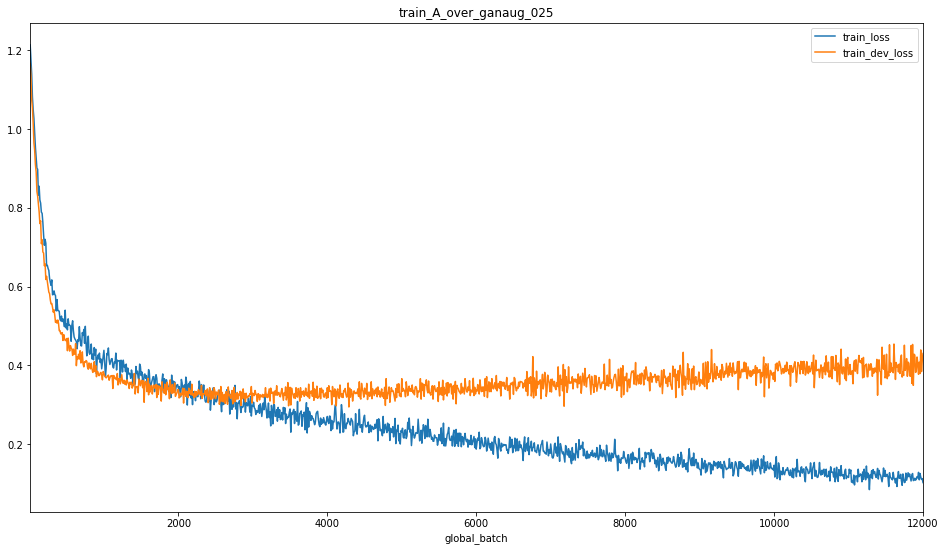

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.8005,0.7395
2,0.5150,0.4735
3,0.4545,0.4060
4,0.4120,0.3730
5,0.3815,0.3545


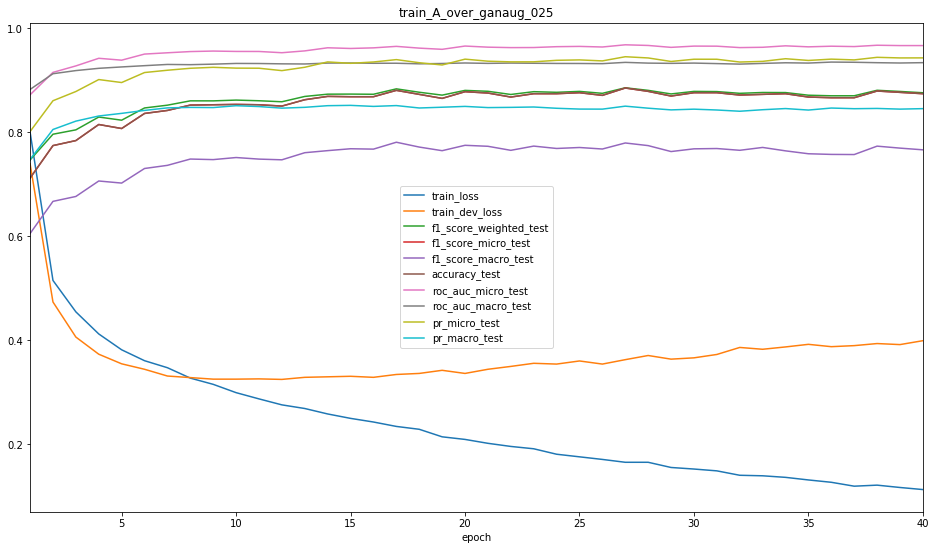

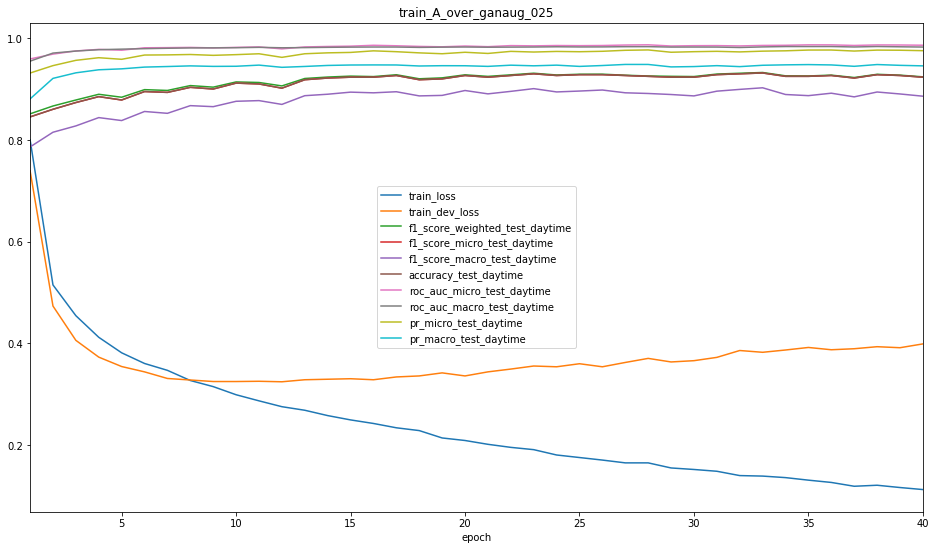

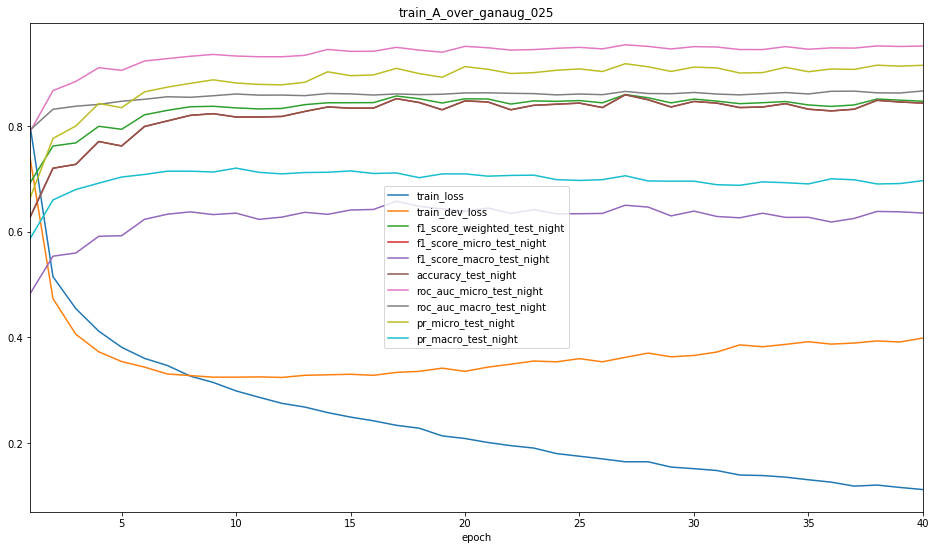

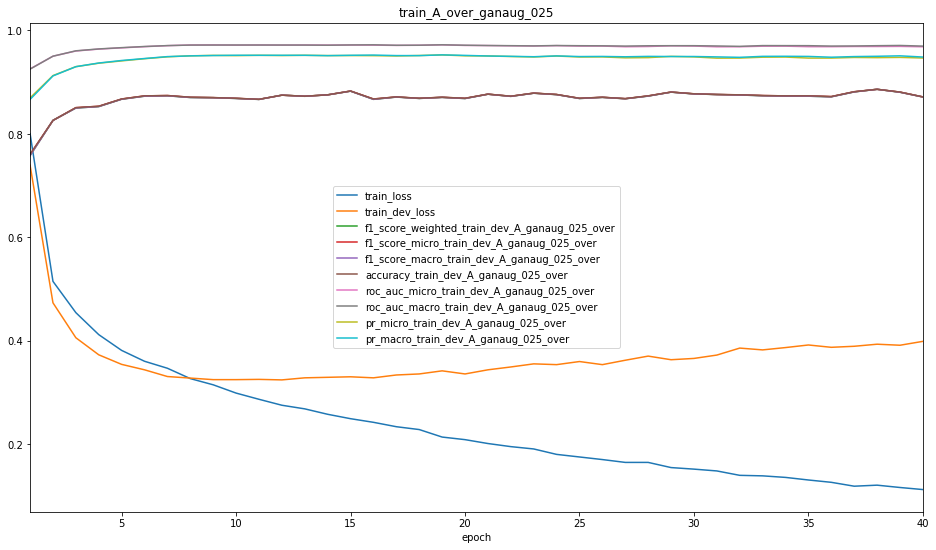

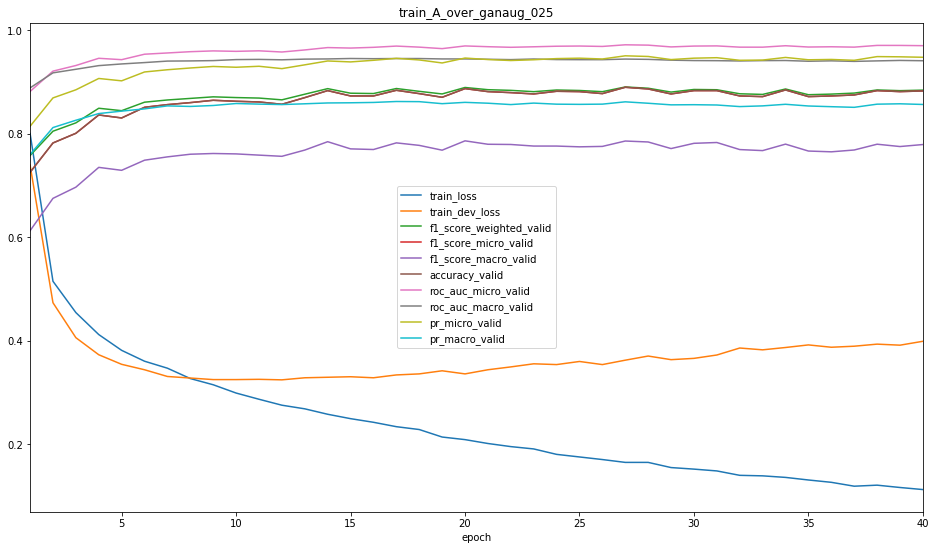

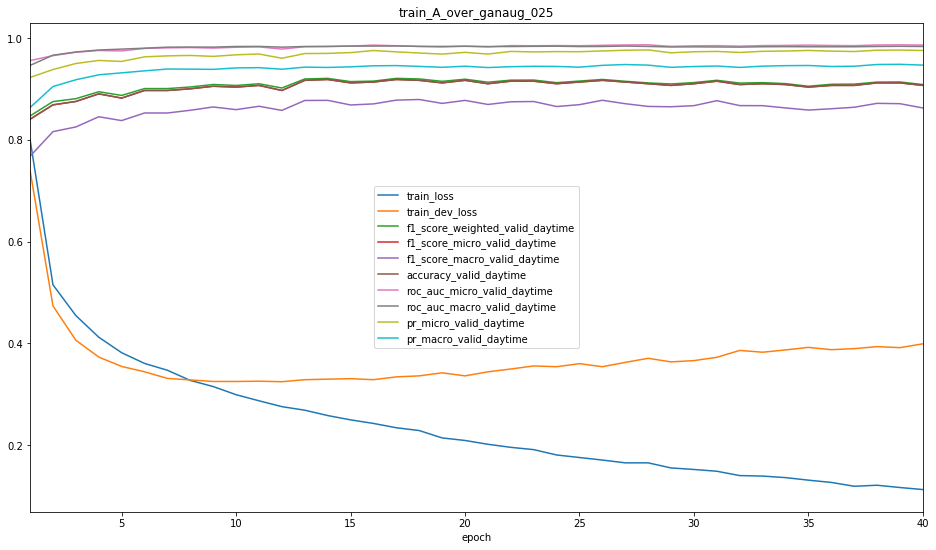

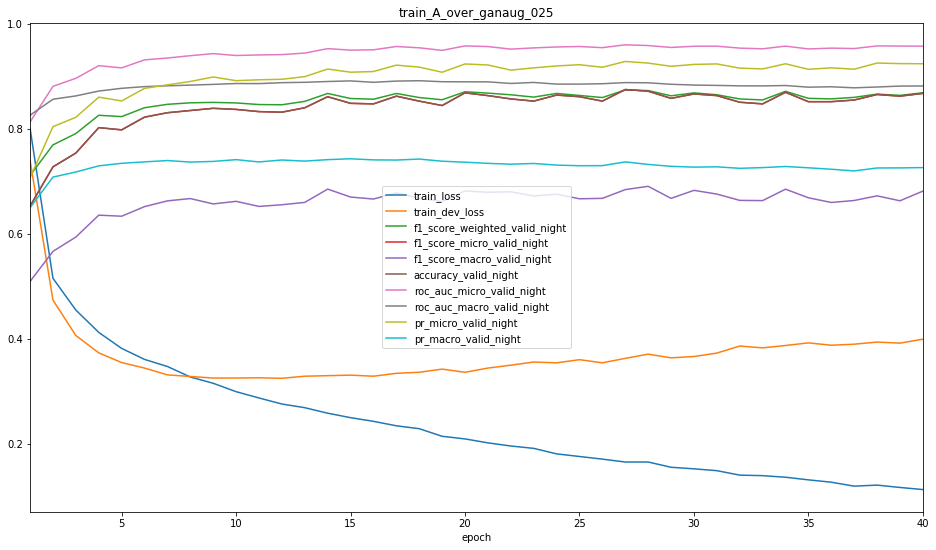

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)